In [1]:
!pip install bar-chart-race==0.1.0

     |████████████████████████████████| 163kB 2.5MB/s 


In [2]:
# import modules and packages

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import bar_chart_race as bcr
import statsmodels.api as sm
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 60)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# define font and figure size of graph
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})

In [4]:
time_series_data = 'https://raw.githubusercontent.com/ajakaiye33/covid19Naija/master/covid19Naija/data/Records_covid19.csv'
non_time_series_data = 'https://raw.githubusercontent.com/ajakaiye33/covid19Naija/master/covid19Naija/data/casses15082020.csv'

In [5]:
#Loading Data

def load_tm_data():
    #print('f Loading data from {filename} ...')
    df = pd.read_csv(time_series_data, parse_dates=['Dates'], index_col='Dates')
    print(f'shape of data {df.shape}')
    print(f'checking for missing values {df.info()}')
    return df

def load_ntm_data():
    #print(f'Loading data from .. {file_name}')
    df = pd.read_csv(non_time_series_data)
    print(f'shape of data: {df.shape}')
    print(f'checking for missing data: {df.info()}')
    return df

#deathby_state = pd.read_csv('data/cases27062020.csv')

In [6]:

covid_ng2 = load_ntm_data()

shape of data: (37, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   States Affected               37 non-null     object
 1   No. of Cases (Lab Confirmed)  37 non-null     object
 2   No. of Cases (on admission)   37 non-null     object
 3   No. Discharged                37 non-null     object
 4   No. of Deaths                 37 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.6+ KB
checking for missing data: None


In [7]:
covid_ng = load_tm_data()

shape of data (177, 40)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177 entries, 2020-02-27 15:40:00 to 2020-08-14 15:21:00
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Lagos                177 non-null    int64
 1   Abuja(FCT)           177 non-null    int64
 2   Kano                 177 non-null    int64
 3   Ogun                 177 non-null    int64
 4   Osun                 177 non-null    int64
 5   Gombe                177 non-null    int64
 6   Katsina              177 non-null    int64
 7   Borno                177 non-null    int64
 8   Edo                  177 non-null    int64
 9   Oyo                  177 non-null    int64
 10  Kwara                177 non-null    int64
 11  Akwa Ibom            177 non-null    int64
 12  Bauchi               177 non-null    int64
 13  Kaduna               177 non-null    int64
 14  Ekiti                177 non-null    int64
 15  Ondo         

In [8]:
#format header columns
def clean_col(name):
    #print('pretifying the column names')
    pretify_name = name.strip().lower().replace(" ", "_").replace('/','_')
    return pretify_name


## clean columns
clean_covid_ng2 = covid_ng2.rename(columns=clean_col)
clean_covid_ng = covid_ng.rename(columns=clean_col)
columns = {}
for col in clean_covid_ng.columns:
    if col == 'abuja(fct)':
        columns['abuja(fct)'] = 'abuja'
    elif col == 'dealth':
        columns['dealth'] = 'deaths'
    elif col == 'dischared_revovered':
        columns['dischared_revovered'] = 'discharged_recovered'
clean_covid_ng.rename(columns=columns, inplace=True)

In [9]:
## see columns
clean_covid_ng2.columns.to_list()
for i,j in enumerate(clean_covid_ng.columns.to_list()):
    print(i,j)

0 lagos
1 abuja
2 kano
3 ogun
4 osun
5 gombe
6 katsina
7 borno
8 edo
9 oyo
10 kwara
11 akwa_ibom
12 bauchi
13 kaduna
14 ekiti
15 ondo
16 delta
17 rivers
18 jigawa
19 enugu
20 niger
21 abia
22 zamfara
23 sokoto
24 benue
25 anambra
26 adamawa
27 plateau
28 imo
29 kebbi
30 kogi
31 nasarawa
32 taraba
33 yobe
34 bayelsa
35 ebonyi
36 cross_river
37 discharged_recovered
38 deaths
39 total_daily_cases


In [10]:
#south_west = ['lagos', 'ondo', 'osun','oyo','ekiti','ogun']


#Extract geopolitical zone
def extract_features(df):
    df['south_west'] = df['lagos'] + df['ondo'] + df['osun'] + df['oyo'] + df['ekiti'] + df['ogun']
    df['south_south'] = df['edo'] + df['rivers'] + df['delta'] + df['cross_river'] + df['bayelsa'] + df['akwa_ibom']
    df['south_east'] = df['anambra'] + df['imo'] + df['enugu'] + df['abia'] + df['ebonyi']
    df['north_central'] = df['benue'] + df['kogi'] + df['nasarawa'] + df['niger'] + df['plateau'] + df['kwara'] + df['abuja']
    df['north_east'] = df['adamawa'] + df['bauchi'] + df['borno'] + df['gombe'] + df['taraba'] + df['yobe']
    df['north_west'] = df['jigawa'] + df['kaduna'] + df['kano'] + df['katsina'] + df['kebbi'] + df['sokoto'] + df['zamfara']
    return df.head(2)


In [11]:
extract_features(clean_covid_ng)


lagos  abuja  kano  ogun  osun  gombe  katsina  borno  \
Dates                                                                        
2020-02-27 15:40:00      1      0     0     0     0      0        0      0   
2020-02-28 01:00:00      0      0     0     0     0      0        0      0   

                     edo  oyo  kwara  akwa_ibom  bauchi  kaduna  ekiti  ondo  \
Dates                                                                          
2020-02-27 15:40:00    0    0      0          0       0       0      0     0   
2020-02-28 01:00:00    0    0      0          0       0       0      0     0   

                     delta  rivers  jigawa  enugu  niger  abia  zamfara  \
Dates                                                                     
2020-02-27 15:40:00      0       0       0      0      0     0        0   
2020-02-28 01:00:00      0       0       0      0      0     0        0   

                     sokoto  benue  anambra  adamawa  plateau  imo  kebbi  \
Dates                                                                       
2020-02-27 15:40:00       0      0        0        0        0    0      0   
2020-02-28 01:00:00       0      0        0        0        0    0      0   

                     kogi  nasarawa  taraba  yobe  bayelsa  ebonyi  \
Dates                                                                
2020-02-27 15:40:00     0         0       0     0        0       0   
2020-02-28 01:00:00     0         0       0     0        0       0   

                     cross_river  discharged_recovered  deaths  \
Dates                                                            
2020-02-27 15:40:00            0                     0       0   
2020-02-28 01:00:00            0                     0       0   

                     total_daily_cases  south_west  south_south  south_east  \
Dates                                                                         
2020-02-27 15:40:00                  1           1            0           0   
2020-02-28 01:00:00                  0           0            0           0   

                     north_central  north_east  north_west  
Dates                                                       
2020-02-27 15:40:00              0           0           0  
2020-02-28 01:00:00              0           0           0

In [12]:
#extract model data
def m_data(df):
    m_data = df[['total_daily_cases', 'deaths', 'discharged_recovered']]
    return m_data
model_data = m_data(clean_covid_ng)

# extract Geopolitcal zone
def zones(df):
    zone_data = df[['south_west','south_south', 'south_east', 'north_central','north_east','north_west']]
    melt_zone = zone_data.melt(value_vars=['south_west','south_south', 'south_east', 'north_central','north_east','north_west'],
                                 var_name='geopolitical_zones', value_name='daily_zone_cases')
    group_by_zone = melt_zone.groupby('geopolitical_zones').agg({'daily_zone_cases': 'sum'}).reset_index()
    sort_by_zonal_cases =  group_by_zone.sort_values('daily_zone_cases', ascending=False)
    return sort_by_zonal_cases
    
geopolitical_zone = zones(clean_covid_ng)
geopolitical_zone

geopolitical_zones  daily_zone_cases
5         south_west             23149
0      north_central              8283
4        south_south              6718
2         north_west              4824
3         south_east              3204
1         north_east              2275

## Cases By Geopolitical Zones

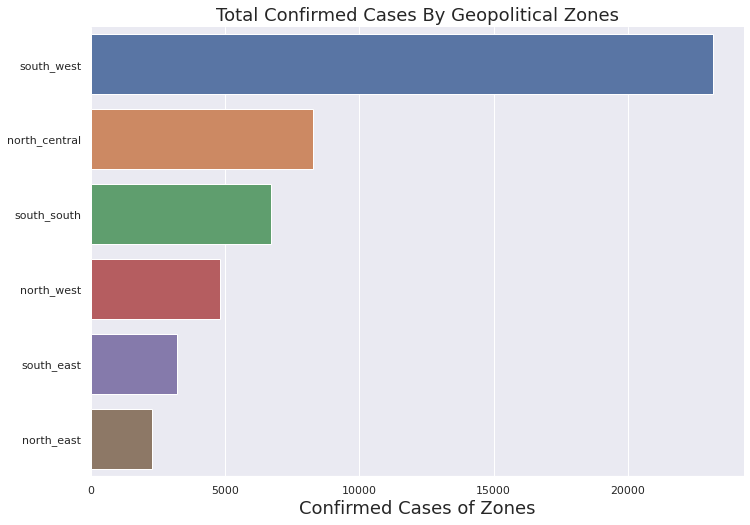

In [13]:
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='daily_zone_cases', y='geopolitical_zones', data=geopolitical_zone);
ax.set_title('Total Confirmed Cases By Geopolitical Zones', size = 18)
ax.set_xlabel('Confirmed Cases of Zones', size=18)
ax.set_ylabel('', size=18)
sns.despine(left=True)
plt.xticks(rotation=360)
plt.show()

## Medical Statistics

#### Case Fatality Rate(CFR)
$$\large CFR = \frac{Total Number of Death}{Total number Infected}$$

In [14]:
def case_fatality(df):
    total_death = df['deaths'].sum()
    total_confirm_cases = df['total_daily_cases'].sum()
    cfr = total_death/total_confirm_cases * 100
    return cfr
cfr = case_fatality(model_data)

print(f'The Case Fatality rate In Nigeria is: {round(cfr,1)}%')

The Case Fatality rate In Nigeria is: 2.0%


#### Mortality Rate
$$\large MR = \frac{Total Population}{Total Deaths}$$ 
[Estimated population of Nigeria](https://en.wikipedia.org/wiki/Demographics_of_Nigeria): 200 Million

In [15]:
def mortality_rate(df):
    estimated_population = 200000000
    covid_deaths = df['deaths'].sum()
    mr = covid_deaths/estimated_population
    return mr
mr = mortality_rate(model_data)
death_per1million = model_data['deaths'].sum()/1000000
print(f'The Mortality Rate of Covid19: {mr}, whereas deaths per one million is:{death_per1million}')

The Mortality Rate of Covid19: 4.865e-06, whereas deaths per one million is:0.000973


## Monthly Statistics

## Confirmed Cases By Month

In [16]:
def monthly_stats(df):
    #make_date_index = df.set_index(data_column)
    monthly_data = df.resample('M').agg({'deaths':'sum', 'total_daily_cases':'sum','discharged_recovered':'sum'})
    monthly_data['dates'] = monthly_data.index
    monthly_data['month'] = monthly_data['dates'].dt.month
    return monthly_data.drop('dates', axis=1)
df_month = monthly_stats(model_data)
df_month


deaths  total_daily_cases  discharged_recovered  month
Dates                                                             
2020-02-29       0                  1                     0      2
2020-03-31       2                137                     9      3
2020-04-30      56               1792                   310      4
2020-05-31     229               8232                  2688      5
2020-06-30     303              15533                  6739      6
2020-07-31     289              17457                  9819      7
2020-08-31      94               5285                 16433      8

### Monthly Confirmed Cases

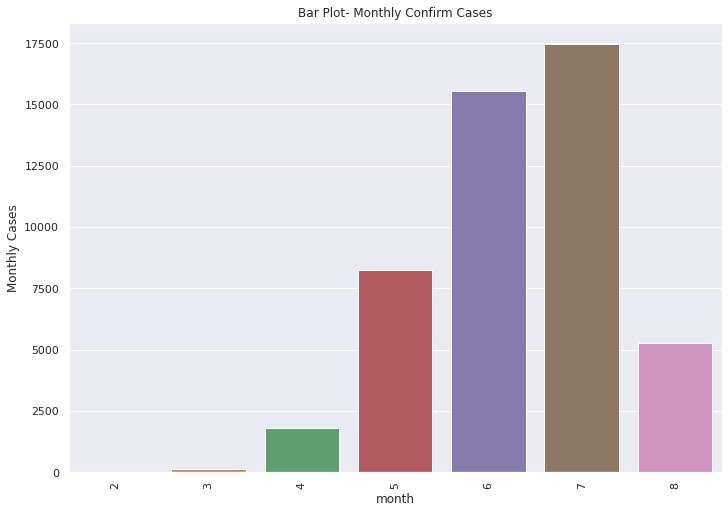

In [17]:
# Monthly confirmed cases
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='total_daily_cases', data=df_month)
ax.set_title('Bar Plot- Monthly Confirm Cases')
ax.set_ylabel('Monthly Cases')
plt.xticks(rotation = 90)
plt.show()

## Deaths By Month

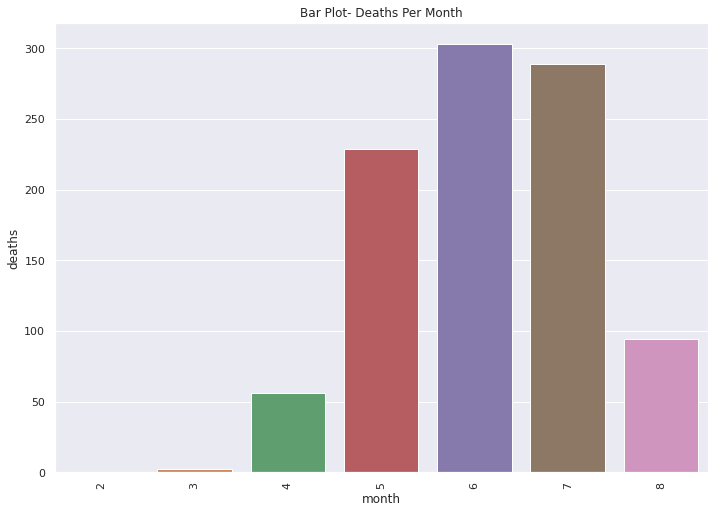

In [18]:
#Monthly Deaths
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='deaths', data=df_month)
ax.set_title('Bar Plot- Deaths Per Month')
plt.xticks(rotation = 90)
plt.show()

## Recoveries By Month

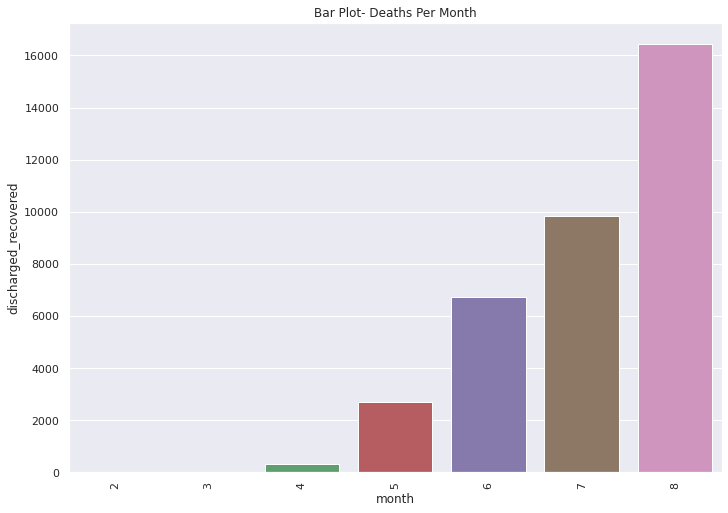

In [19]:
#Number of Recoveries by Month
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='discharged_recovered', data=df_month)
ax.set_title('Bar Plot- Deaths Per Month')
plt.xticks(rotation = 90)
plt.show()

## States Data

In [20]:
state_data = load_ntm_data()
state_data.head()

shape of data: (37, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   States Affected               37 non-null     object
 1   No. of Cases (Lab Confirmed)  37 non-null     object
 2   No. of Cases (on admission)   37 non-null     object
 3   No. Discharged                37 non-null     object
 4   No. of Deaths                 37 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.6+ KB
checking for missing data: None


States Affected No. of Cases (Lab Confirmed) No. of Cases (on admission)  \
0           Lagos                       16,369                       1,711   
1             FCT                        4,665                       3,277   
2             Oyo                        2,943                       1,381   
3             Edo                        2,414                         183   
4          Rivers                        1,993                         152   

  No. Discharged  No. of Deaths  
0         14,457            201  
1          1,342             46  
2          1,530             32  
3          2,131            100  
4          1,785             56

In [21]:
#clean_data
second_data = load_ntm_data()
affected_column = ['no._of_cases_(lab_confirmed)', 'no._of_cases_(on_admission)','no._discharged']
def polish_data(df):
    clean_columns = df.rename(columns=clean_col)
    for i in clean_columns.columns:
        if i in affected_column:
            clean_columns[i] = clean_columns[i].str.replace(',','').astype('int64')
    return clean_columns
cleany = polish_data(second_data)
cleany.head()

shape of data: (37, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   States Affected               37 non-null     object
 1   No. of Cases (Lab Confirmed)  37 non-null     object
 2   No. of Cases (on admission)   37 non-null     object
 3   No. Discharged                37 non-null     object
 4   No. of Deaths                 37 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.6+ KB
checking for missing data: None


states_affected  no._of_cases_(lab_confirmed)  no._of_cases_(on_admission)  \
0           Lagos                         16369                         1711   
1             FCT                          4665                         3277   
2             Oyo                          2943                         1381   
3             Edo                          2414                          183   
4          Rivers                          1993                          152   

   no._discharged  no._of_deaths  
0           14457            201  
1            1342             46  
2            1530             32  
3            2131            100  
4            1785             56

In [22]:
def states_stat(df,st_col, st_death):
    death_by_state =  df[[st_col, st_death]].sort_values(st_death, ascending=False)
    return death_by_state
death_by_states = states_stat(cleany,'states_affected', 'no._of_deaths')


## Deaths By States

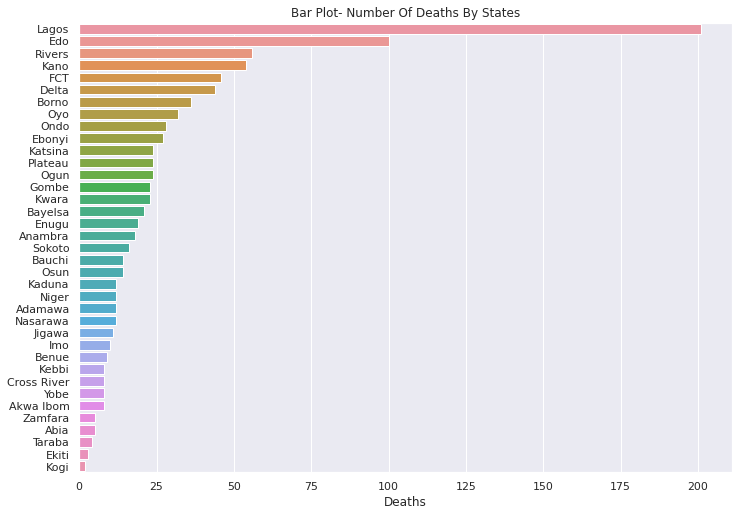

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._of_deaths', y='states_affected', data=death_by_states)
ax.set_title('Bar Plot- Number Of Deaths By States')
plt.xlabel('Deaths')
plt.ylabel('')
#plt.yticks(rotation=90)
plt.show()

## Recovery Rates By State

In [57]:
def recov_ratio(df, st_col, recov_col, conf_cases, new_col):
  df[new_col] = df[recov_col] / df[conf_cases]
  recovey_ratio = df[[st_col, new_col]].sort_values(new_col, ascending=False)
  return recovey_ratio
state_recov_ratio = recov_ratio(cleany, 'states_affected','no._discharged','no._of_cases_(lab_confirmed)','recov_ratio')
state_recov_ratio.head()

states_affected  recov_ratio
24          Jigawa     0.956522
12          Ebonyi     0.935236
19          Bauchi     0.924269
33         Zamfara     0.922078
23         Bayelsa     0.911932

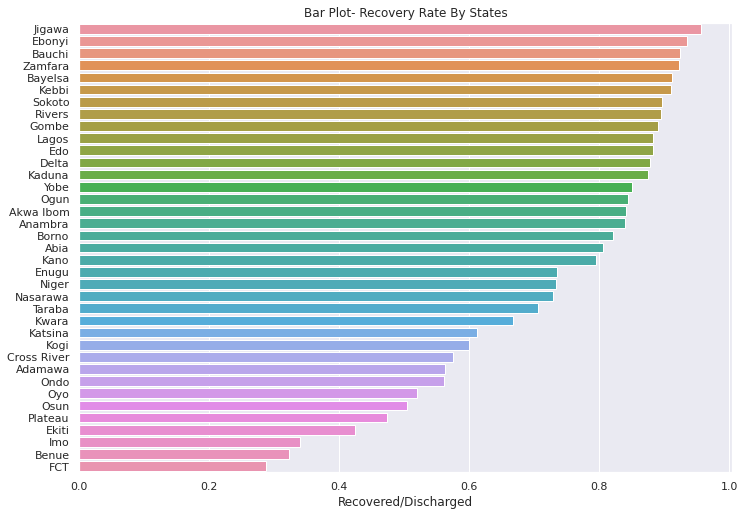

In [58]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='recov_ratio', y='states_affected', data=state_recov_ratio)
ax.set_title('Bar Plot- Recovery Rate By States')
plt.xlabel('Recovered/Discharged')
plt.ylabel('')
#plt.yticks(rotation=90)
plt.show()

## Recoveries/Discharged By States

In [24]:
discharged_by_states = states_stat(cleany, 'states_affected', 'no._discharged')


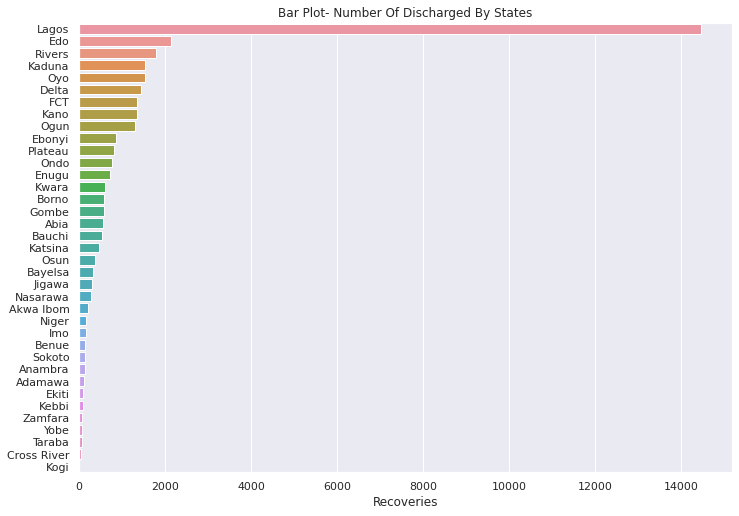

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._discharged',y='states_affected', data=discharged_by_states)
ax.set_title('Bar Plot- Number Of Discharged By States')
plt.xlabel('Recoveries')
plt.ylabel('')
#plt.xticks(rotation=90)
plt.show()

## confirmed Cases By States

In [26]:
confirmed_cases_states = states_stat(cleany,'states_affected', 'no._of_cases_(lab_confirmed)')


### Confirmed Cases By States

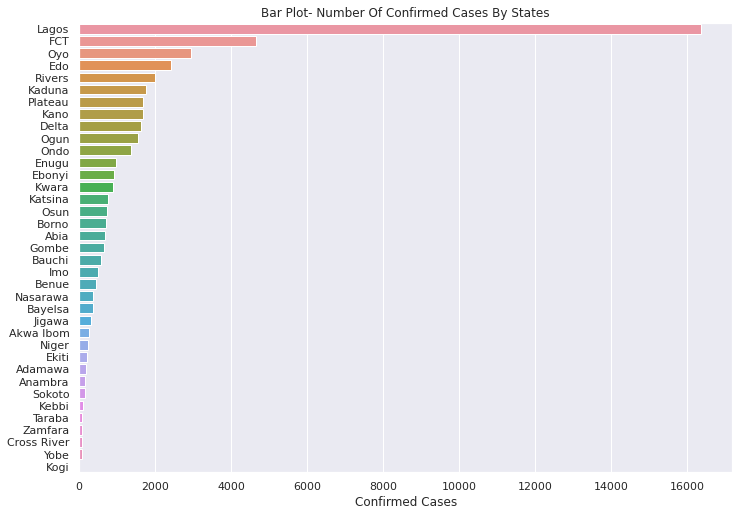

In [27]:
# Confirm cases spread across all states
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._of_cases_(lab_confirmed)',y='states_affected', data=confirmed_cases_states)
ax.set_title('Bar Plot- Number Of Confirmed Cases By States')
plt.xlabel('Confirmed Cases')
plt.ylabel('')
#plt.xticks(rotation=90)
plt.show()

## Race Bar Chart

In [28]:
#get data into shape
nt_needed = ['discharged_recovered','deaths','total_daily_cases','south_west','south_south','south_east','north_central','north_east','north_west']
def tidyrc_data(df):
    race_chart_data = df.drop(nt_needed, axis=1)
    clean_rc_data = race_chart_data.cumsum(axis=0)
    return clean_rc_data

clean_rb = tidyrc_data(clean_covid_ng)



In [29]:
bcr.bar_chart_race(clean_rb)

## Build  Logistic Model

### Predicting the Epidemic Situation of Covid19 In Nigeria with Logistic Mathematical Model
My choice of the Logistic Model is simply because it is simple and it conform to the statistical law of Epidemiology

In [30]:
#Preapre data
def clean_model_data(df):
    cumulate_data = df.cumsum(axis=0)
    clean_index = cumulate_data.reset_index()
    return clean_index
log_model_data = clean_model_data(model_data)


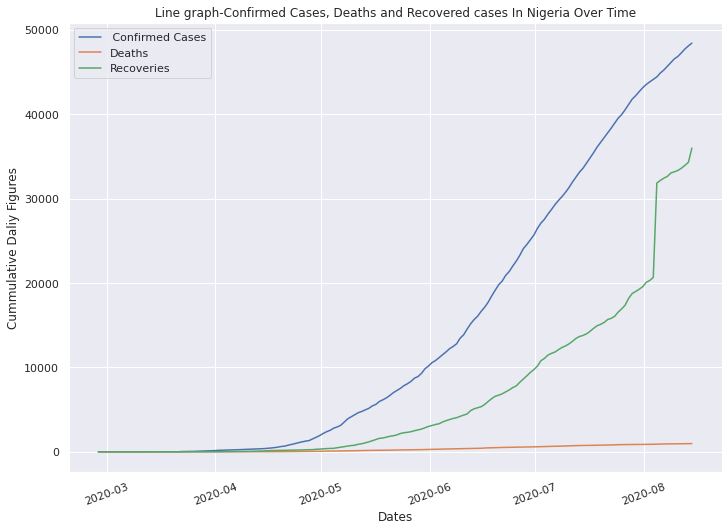

In [31]:
#Line graph of confirm cases over time
ax = sns.lineplot(x='Dates', y='total_daily_cases', data=log_model_data, label=' Confirmed Cases')
ax = sns.lineplot(x='Dates', y='deaths', data=log_model_data,label='Deaths')
ax = sns.lineplot(x='Dates', y='discharged_recovered', data=log_model_data, label='Recoveries')
plt.xticks(rotation=20)
ax.set_title('Line graph-Confirmed Cases, Deaths and Recovered cases In Nigeria Over Time')
ax.set_ylabel('Cummulative Daliy Figures')
ax.legend()
plt.show()




## Logistic Model
The logistic model can be simply rendered as $$\huge f(x;a,b,c) = \frac{c}{1 + e^-(x-b)/a}$$ 

where :
- a = **Infection speed**
- b = **Day with maximum Infections Occured**
- c = **Total Number of people that would be infected at the end of the pandemic**

In [32]:
def logistic_model(x,a,b,c,d):
    return a / (1 + np.exp(-c * (x - d))) + b

# def logistics_noise(a,b,c,d,t):
#     return abs(c/(1+a*np.exp(-b*t))+np.random.normal(0,d))

In [33]:
def build_data(df):
    df['time_stamp'] = df.index
    return df
build_model = build_data(log_model_data)
build_model.tail()

Dates  total_daily_cases  deaths  discharged_recovered  \
172 2020-08-10 15:21:00              46859     950                 33346   
173 2020-08-11 15:21:00              47282     956                 33609   
174 2020-08-12 15:21:00              47735     956                 33943   
175 2020-08-13 15:21:00              48108     966                 34309   
176 2020-08-14 15:21:00              48437     973                 35998   

     time_stamp  
172         172  
173         173  
174         174  
175         175  
176         176

In [34]:
# extract x(days) & y(cases) from dataframe
x = list(build_model.iloc[:,4])
y = list(build_model.iloc[:,1])


In [35]:
# randomly initialize a,b,c,d
p0 = np.random.exponential(size=4)
p0


array([0.90286688, 0.01356368, 2.50603328, 0.14715153])

In [36]:
# set upper and lower bounds a,b,c
bounds = (0,[10000000., 2., 100000000., 100000000.])
bounds

(0, [10000000.0, 2.0, 100000000.0, 100000000.0])

In [37]:
(a_, b_, c_,d_), cov = curve_fit(logistic_model,x,y,bounds=bounds, p0=p0)

In [38]:
a_,b_,c_,d_

(54250.31191796939,
 4.928904400122297e-13,
 0.04691364194823438,
 133.50402719346894)

In [39]:
#the time step at which the growth is fastest
# t_fastest = np.log(a) / b
# i_fastest = logistic_model(t_fastest, a, b, c)
# i_fastest

In [40]:
conex = np.array(y)
conex

array([    1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     2,     2,     2,     2,     2,     2,     2,
           2,     3,     3,     3,     3,     6,    27,    39,    43,
          45,    50,    64,    69,    80,    88,    96,   110,   130,
         134,   138,   150,   173,   183,   189,   213,   223,   231,
         237,   253,   275,   289,   306,   319,   324,   344,   363,
         374,   408,   443,   494,   543,   629,   667,   784,   875,
         983,  1097,  1184,  1270,  1335,  1530,  1726,  1930,  2168,
        2388,  2557,  2802,  2950,  3145,  3525,  3911,  4150,  4398,
        4640,  4786,  4968,  5157,  5445,  5621,  5959,  6167,  6393,
        6677,  7016,  7261,  7526,  7839,  8068,  8344,  8733,  8915,
        9302,  9855, 10162, 10578, 10819, 11167, 11517, 11845, 12227,
       12487, 12802, 13465, 13874, 14555, 15182, 15683, 16086, 16659,
       17149, 17736, 18481, 19148, 19809, 20245, 20920, 21372, 22021,
       22615, 23299,

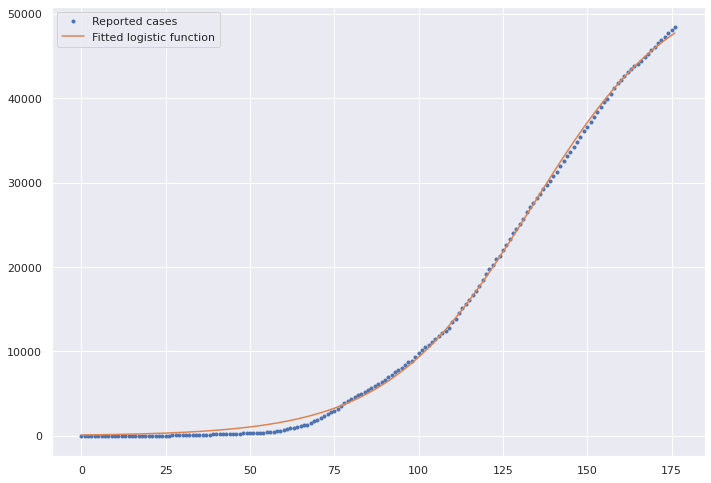

In [41]:
def plot_logistic_fit(confirmed, logistic_params):
    a_, b_, c_,d_ = logistic_params
    x = np.arange(0, len(build_model['time_stamp']))
    plt.plot(x, confirmed, ".", label="Reported cases")
    confirmed_pred = logistic_model(x, a_, b_, c_,d_)
    plt.plot(x, confirmed_pred, label="Fitted logistic function")
    plt.legend()
    plt.show()
    return confirmed_pred
confirmed_pred = plot_logistic_fit(conex, (a_, b_, c_,d_))


In [42]:
from sklearn.metrics import r2_score

In [43]:
#check goodness of fit measure
r2_score(y,confirmed_pred)

0.9991984455982829

In [44]:
def plateau(confirmed, logistic_params,diff=200):
  a_, b_, c_, d_ = logistic_params
  confirm_now = confirmed[-1]
  confirmed_then = confirmed[-2]
  days = 0
  now = x[-1]
  while confirm_now - confirmed_then > diff:
    days += 1
    confirmed_then = confirm_now
    confirm_now = logistic_model(now + days, a_, b_, c_, d_)
  return days, confirm_now
days, confirmy = plateau(y,(a_, b_, c_, d_))
days, confirmy

(1, 48010.96824921079)

In [45]:
print(f"last day's case:{conex[-1] - conex[-2]}")


last day's case:329


## Focasting with Facebook's Prophet Package
To use this package for logistic growth, a carrying capacity mst be estimated/calculated

In [46]:
# carrying cappacity from above logistic growth model
t_fastest = np.log(a_)/b_
t_fastest

22117215381080.79

In [47]:
check_fastest = logistic_model(t_fastest, a_, b_, c_, d_)
check_fastest

54250.31191796939

In [48]:
# wrangle dataframe to fit prophet requirement
def forecast_data(df):
  df['ds'] = df['Dates']
  df['y'] = df['total_daily_cases'] 
  df['cap'] = check_fastest
  prof_df = df[['ds', 'y', 'cap']]
  return prof_df
prophet_data =  forecast_data(build_model)
prophet_data.head()


ds  y           cap
0 2020-02-27 15:40:00  1  54250.311918
1 2020-02-28 01:00:00  1  54250.311918
2 2020-02-29 02:26:00  1  54250.311918
3 2020-03-01 22:44:00  1  54250.311918
4 2020-03-02 11:53:00  1  54250.311918

In [49]:
m = Prophet(growth='logistic')
m.fit(prophet_data)
future = m.make_future_dataframe(periods=30)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [50]:
future['cap'] = prophet_data['cap'].iloc[0]
forecast = m.predict(future)

In [51]:
forecast.tail()

ds         trend           cap    yhat_lower  \
202 2020-09-09 15:21:00  52429.047913  54250.311918  51235.981463   
203 2020-09-10 15:21:00  52512.892447  54250.311918  51429.106680   
204 2020-09-11 15:21:00  52592.999091  54250.311918  51464.721825   
205 2020-09-12 15:21:00  52669.523467  54250.311918  51525.682322   
206 2020-09-13 15:21:00  52742.615717  54250.311918  51545.678930   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
202  52135.861589  52415.185113  52441.994166     -744.192159   
203  52321.662001  52498.833418  52525.938700     -648.206690   
204  52389.064817  52578.693707  52606.025409     -659.509225   
205  52401.286615  52655.005939  52682.564995     -719.067410   
206  52428.660336  52727.841844  52755.644119     -742.042482   

     additive_terms_lower  additive_terms_upper       daily  daily_lower  \
202           -744.192159           -744.192159 -709.809744  -709.809744   
203           -648.206690           -648.206690 -709.809744  -709.809744   
204           -659.509225           -659.509225 -709.809744  -709.809744   
205           -719.067410           -719.067410 -709.809744  -709.809744   
206           -742.042482           -742.042482 -709.809744  -709.809744   

     daily_upper     weekly  weekly_lower  weekly_upper  multiplicative_terms  \
202  -709.809744 -34.382415    -34.382415    -34.382415                   0.0   
203  -709.809744  61.603054     61.603054     61.603054                   0.0   
204  -709.809744  50.300520     50.300520     50.300520                   0.0   
205  -709.809744  -9.257666     -9.257666     -9.257666                   0.0   
206  -709.809744 -32.232738    -32.232738    -32.232738                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
202                         0.0                         0.0  51684.855754  
203                         0.0                         0.0  51864.685758  
204                         0.0                         0.0  51933.489866  
205                         0.0                         0.0  51950.456057  
206                         0.0                         0.0  52000.573235

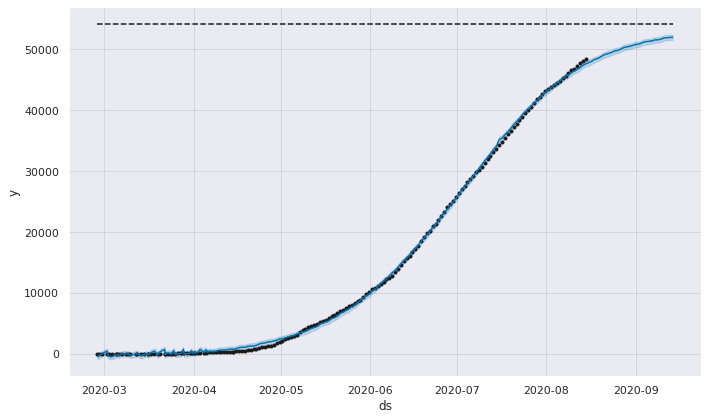

In [52]:
fig = m.plot(forecast)

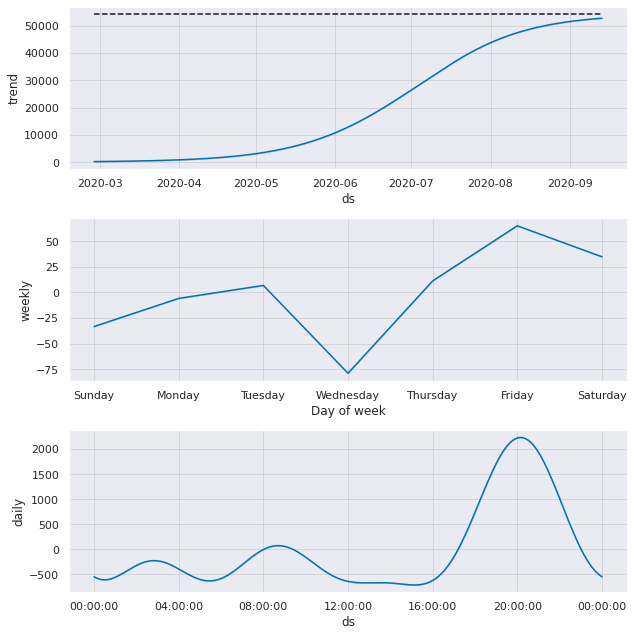

In [53]:
fig2 = m.plot_components(forecast)